# Анализ выгрузки финансов

Эта тетрадка сделана, чтобы разрабатывать и тестировать функции бота

## Загрузка данных

In [588]:
# импорт библиотек
# работа с данными
import numpy as np
import pandas as pd

# графика
from matplotlib import pyplot as plt
from matplotlib import ticker
import seaborn as sns

# работа с моделями машинного обучения
import torch
import torch.nn as nn
import torch.optim as optim
import copy
from sklearn.metrics import mean_squared_error

In [589]:
# чтение csv
df = pd.read_csv('fin.csv', sep=';')

## Предобработка данных

In [590]:
# обзор данных
df.head()

,Дата операции,Дата платежа,Номер карты,Статус,Сумма операции,Валюта операции,Сумма платежа,Валюта платежа,Кэшбэк,Категория,MCC,Описание,Бонусы (включая кэшбэк),Округление на инвесткопилку,Сумма операции с округлением
0,14.03.2025 12:21:06,14.03.2025,*7267,OK,"-700,00",RUB,"-700,00",RUB,7.0,Красота,7230.0,Супермен,"7,00","0,00","700,00"
1,13.03.2025 18:16:07,13.03.2025,*7267,OK,"-964,93",RUB,"-964,93",RUB,9.0,Супермаркеты,5411.0,Пятёрочка,"9,00","0,00","964,93"
2,13.03.2025 11:41:04,13.03.2025,*7267,OK,"-579,94",RUB,"-579,94",RUB,5.0,Супермаркеты,5411.0,Магнит,"5,00","0,00","579,94"
3,13.03.2025 11:22:16,13.03.2025,*7267,OK,"-94,90",RUB,"-94,90",RUB,NaN,Супермаркеты,5411.0,SPAR,"0,00","0,00","94,90"
4,12.03.2025 22:16:04,13.03.2025,*7267,OK,"-906,00",RUB,"-906,00",RUB,45.0,Такси,4121.0,Яндекс Такси,"45,00","0,00","906,00"


In [591]:
# удаление лишних данных
df = df[['Дата операции', 'Сумма операции', 'Категория', 'Описание']]
#df.head()

In [592]:
# анализ типов данных
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3085 entries, 0 to 3084
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Дата операции   3085 non-null   object
 1   Сумма операции  3085 non-null   object
 2   Категория       3070 non-null   object
 3   Описание        3085 non-null   object
dtypes: object(4)
memory usage: 96.5+ KB


In [593]:
# переименование столбцов
df.columns = ['dt', 'sum', 'category', 'description']
df.head()

,dt,sum,category,description
0,14.03.2025 12:21:06,"-700,00",Красота,Супермен
1,13.03.2025 18:16:07,"-964,93",Супермаркеты,Пятёрочка
2,13.03.2025 11:41:04,"-579,94",Супермаркеты,Магнит
3,13.03.2025 11:22:16,"-94,90",Супермаркеты,SPAR
4,12.03.2025 22:16:04,"-906,00",Такси,Яндекс Такси


In [594]:
# приведение типов
df['dt'] = pd.to_datetime(df['dt'], dayfirst=True)
df['sum'] = pd.to_numeric(df['sum'].str.replace(',', '.'))

In [595]:
# Установка индекса
df.index = df['dt']

In [596]:
# сортировка по индексу
df.sort_index(inplace=True)

In [597]:
# добавление столбца баланса
df['balance'] = df['sum'].cumsum()

In [598]:
# анализ содержимого
df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
dt,3085,NaN,NaN,NaN,2023-07-24 21:53:07.212965888,2021-05-10 11:50:01,2022-04-03 14:37:54,2024-01-05 15:46:42,2024-08-27 22:58:10,2025-03-14 12:21:06,NaN
sum,3085.0,NaN,NaN,NaN,-95.432885,-700000.0,-686.83,-245.98,-79.0,770765.02,39463.587553
category,3070,43,Супермаркеты,755,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,3085,439,Пятёрочка,372,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,3085.0,NaN,NaN,NaN,-193616.990347,-526091.92,-468017.56,-140962.57,23151.33,513737.06,259200.448202


## Исследовательский анализ

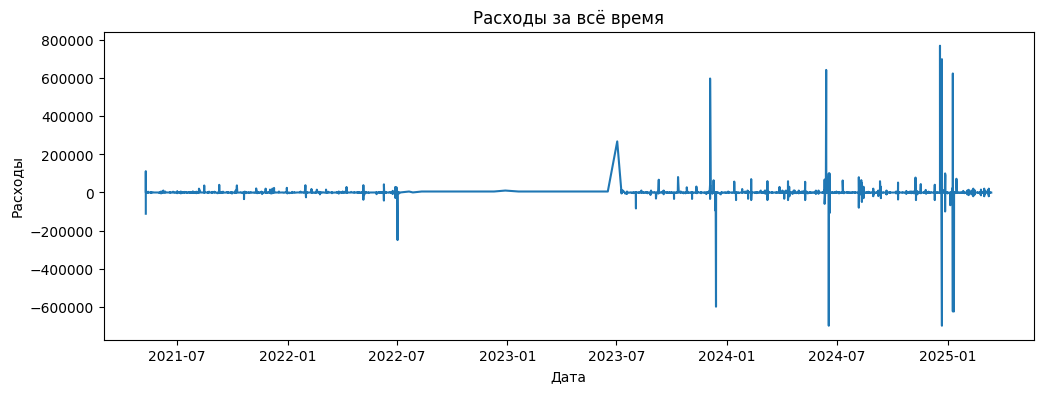

In [599]:
# график трат
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df['sum'])
ax.set_title('Расходы за всё время')
ax.set_xlabel('Дата')
ax.set_ylabel('Расходы')
plt.show()

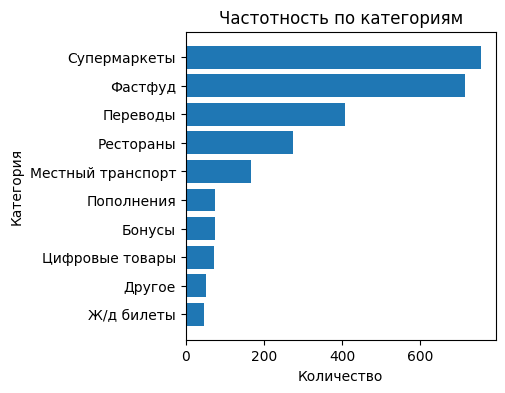

In [600]:
# диаграмма частотности трат по категориям
fig, ax = plt.subplots(figsize=(4, 4))
ax.barh(df['category'].value_counts().sort_values(ascending=False).head(10).index, 
        df['category'].value_counts().sort_values(ascending=False).head(10))
ax.set_xlabel('Количество')
ax.set_ylabel('Категория')
ax.invert_yaxis()
ax.set_title('Частотность по категориям')
plt.show()

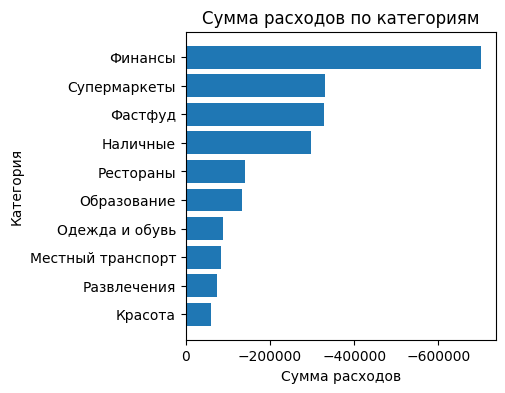

In [601]:
# диаграмма суммы трат по категориям
fig, ax = plt.subplots(figsize=(4, 4))
ax.barh(df.pivot_table(index='category', values='sum', aggfunc='sum').sort_values(by='sum', ascending=True)['sum'].head(10).index, 
        df.pivot_table(index='category', values='sum', aggfunc='sum').sort_values(by='sum', ascending=True)['sum'].head(10))
ax.set_xlabel('Сумма расходов')
ax.set_ylabel('Категория')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Сумма расходов по категориям')
plt.show()

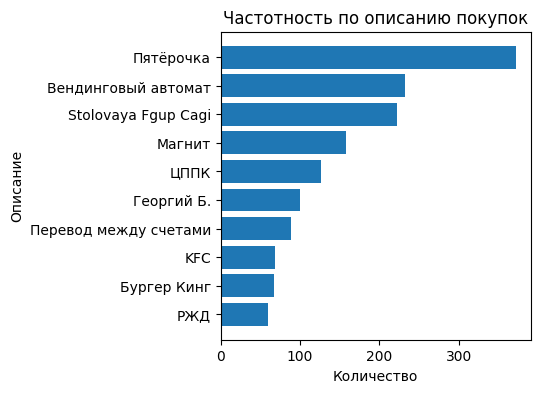

In [602]:
# диаграмма частотности трат по описанию
fig, ax = plt.subplots(figsize=(4, 4))
ax.barh(df['description'].value_counts().sort_values(ascending=False).head(10).index, 
        df['description'].value_counts().sort_values(ascending=False).head(10))
ax.set_xlabel('Количество')
ax.set_ylabel('Описание')
ax.invert_yaxis()
ax.set_title('Частотность по описанию покупок')
plt.show()

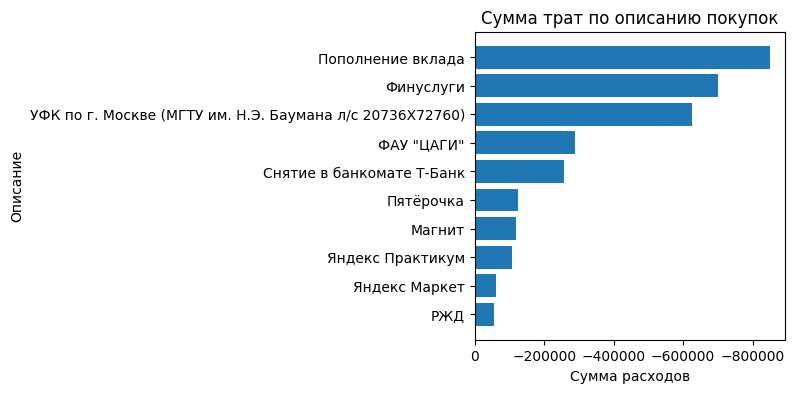

In [603]:
# диаграмма суммы трат по описанию
fig, ax = plt.subplots(figsize=(4, 4))
ax.barh(df.pivot_table(index='description', values='sum', aggfunc='sum').sort_values(by='sum', ascending=True)['sum'].head(10).index, 
        df.pivot_table(index='description', values='sum', aggfunc='sum').sort_values(by='sum', ascending=True)['sum'].head(10))
ax.set_xlabel('Сумма расходов')
ax.set_ylabel('Описание')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_title('Сумма трат по описанию покупок')
plt.show()

## Разработка функционала бота

**Функционал бота**
- Отображение баланса (на подобие кумулятивной функции);
- Сравнение годовых изменений баланса (сабплоты);
- Сравнение месячных трат по категориям;
- Сравнение месячных трат по частоте;
- Оценка среднемесячных расходов;
- Прогноз времени опустошения бюджета.

<Axes: xlabel='dt'>

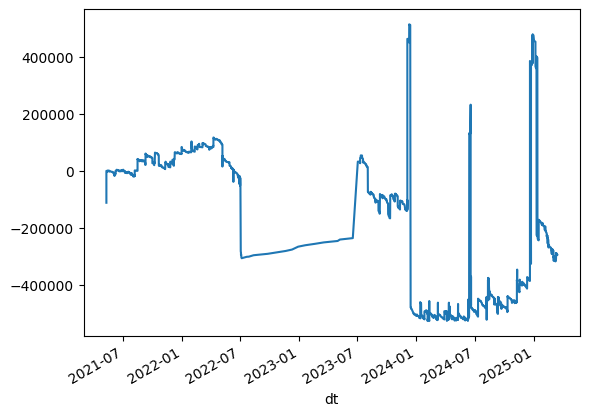

In [604]:
# кумулятивное отображение баланса
df['balance'].plot()


In [605]:
# годовые изменения баланса
def plot_years():
    '''Функция строит график баланса за последние 3 года'''
    # определение последнего года в данных
    last_year = df.index.max().year

    # построение графиков баланса
    fig, ax = plt.subplots(nrows=3, figsize=(16, 10))
    fig.suptitle('Баланс за последние 3 года')
    fig.subplots_adjust(hspace=0.5)

    for i in range(3):
        year = str(last_year - i)
        df.loc[year + '-01-01':year +'-12-31', 'balance'].plot(ax=ax[i])
        
        xticks = ticker.MaxNLocator(12)
        yticks = ticker.MaxNLocator(10)
        ax[i].xaxis.set_major_locator(xticks)
        ax[i].yaxis.set_major_locator(yticks)

        ax[i].grid()
        ax[i].tick_params(labelrotation=0)
        ax[i].set_title(year + ' год')
        ax[i].set_xlabel('Дата')
        ax[i].set_ylabel('Баланс')
    

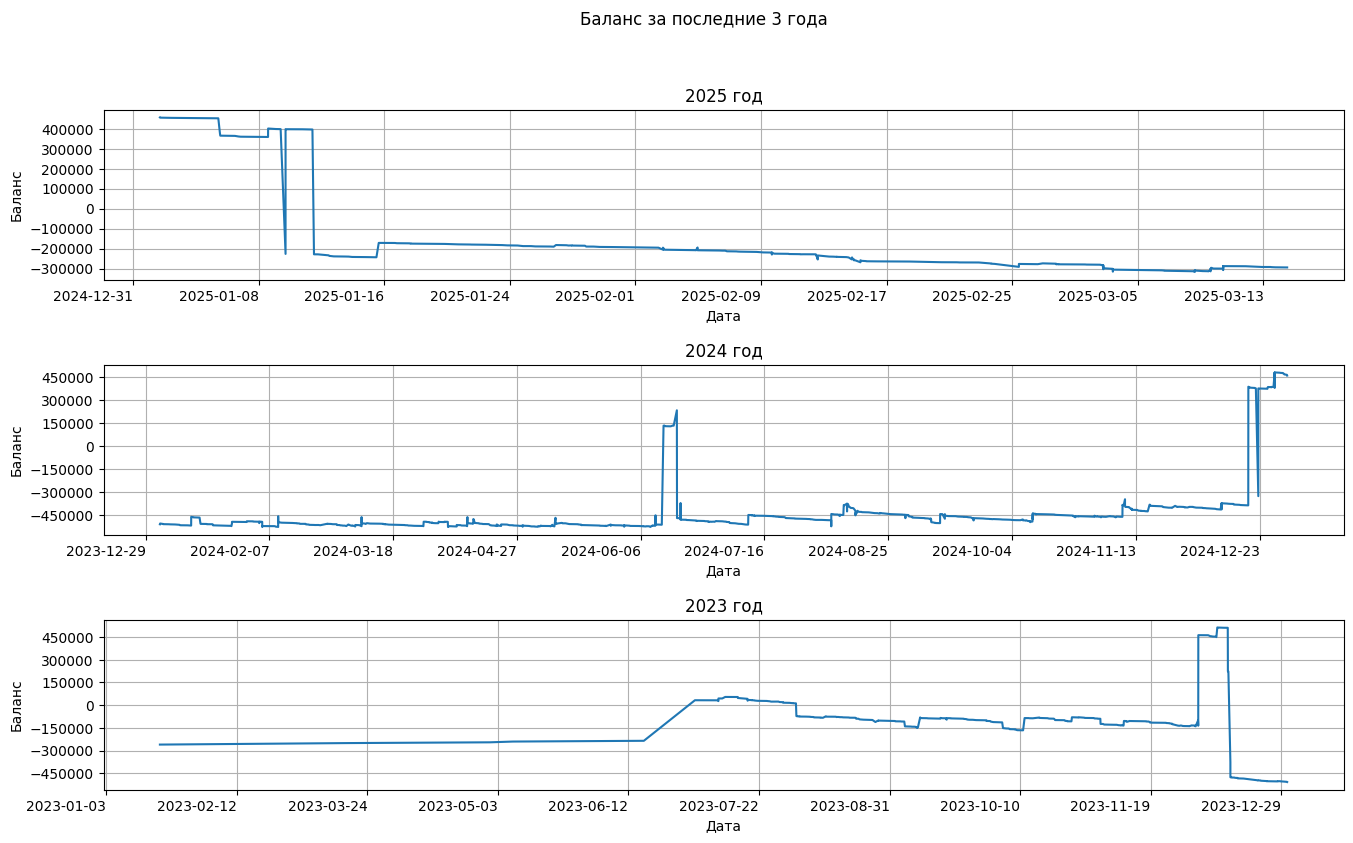

In [606]:
# проверка функции
plot_years()

In [607]:
# месячные траты по категориям
def plot_scats(month, year):
    '''Функция принимает на вход месяц и год. Выводит диаграмму трат по категориям.'''
    # формирование датафрейма месяца
    month_data = df.loc[str(year) + '-' + str(month)]
    month_pivot = month_data.pivot_table(index='category', values='sum', aggfunc='sum')\
        .sort_values(by='sum', ascending=True)['sum']

    # построение графиков
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.barh(month_pivot.index, 
            month_pivot)
    ax.grid()
    ax.set_xlabel('Сумма расходов')
    ax.set_ylabel('Категория')
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.set_title('Сумма расходов по категориям')
    plt.show()

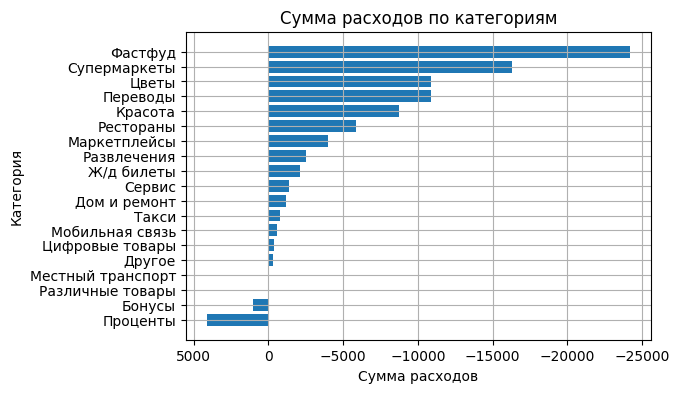

In [608]:
# проверка функции
plot_scats(2, 2025)

In [609]:
# месячные траты по частоте
def plot_rcats(month, year):
    '''Функция принимает на вход месяц и год. Выводит диаграмму трат по частоте.'''
    # формирование датафрейма месяца
    month_data = df.loc[str(year) + '-' + str(month)]
    month_pivot = month_data.pivot_table(index='category', values='sum', aggfunc='count')\
        .sort_values(by='sum', ascending=False)['sum']

    # построение графиков
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.barh(month_pivot.index, 
            month_pivot,
            color='orange')
    ax.grid()
    ax.set_xlabel('Частота расходов')
    ax.set_ylabel('Категория')
    ax.invert_yaxis()
    ax.set_title('Частота расходов по категориям')
    plt.show()

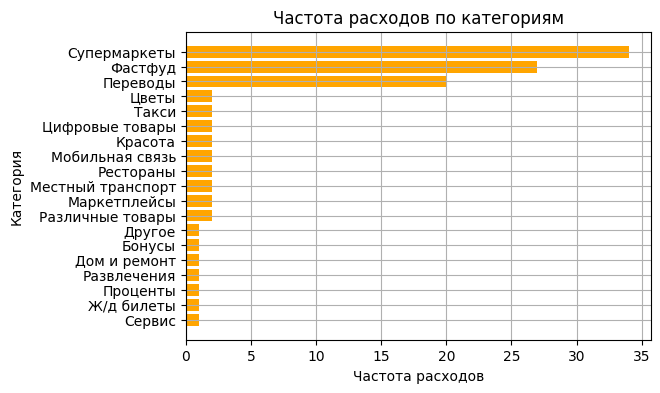

In [610]:
# проверка функции
plot_rcats(2, 2025)

In [611]:
# расчет времени опустошения бюджета
def balance_count():
    '''Функция возвращает количество месяцев, которое можно прожить на текущий баланс.'''
    # определение текущего баланса
    balance = np.abs(df.iloc[-1]['balance'])

    # определение среднемесячных трат
    avg_month = np.abs(df['2023-01-01': '2024-12-31']['sum'].resample('ME').sum().mean())

    # вывод количества месяцев
    print(round(balance/avg_month, 2))

In [612]:
# проверка функции
balance_count()

9.77


## Предсказание трат с помощью torch

In [613]:
# функция для создания дополнительных признаков
def make_features(dataframe, max_lag, rolling_mean_size):
    '''Функция принимает на вход набор данных, максимальную величину лага для признаков отставания,
    размер группировки для скользящей средней'''
    data = dataframe.copy()
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['balance'].shift(lag)

    data['rolling_mean'] = data['balance'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [614]:
# создание признаков
features = make_features(df.drop(['dt', 'category', 'sum', 'description'], axis=1), 30, 7)
features.dropna(inplace=True)

In [615]:
# разделение на тренировочную и тестовую выборки
X_train = features[:-30].drop('balance', axis=1)
y_train = features[:-30]['balance']
X_test = features[-31:].drop('balance', axis=1)
y_test = features[-31:]['balance']

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3025, 34) (31, 34) (3025,) (31,)


In [616]:
# переход к тензорам torch
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

In [617]:
# определение модели нейросети
model = nn.Sequential(
    nn.Linear(34, 48),
    nn.ReLU(),
    nn.Linear(48, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

In [618]:
# функция потерь и оптимизатор
lossFunction = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [619]:
# обучение нейросети
epochs = 400
batch_size = 20

best_mse = np.inf
best_weights = None
history = []

size = X_train.shape[0]

for epoch in range(epochs):
    model.train()

    index = 0

    while index * batch_size <= size:
        
        X_batch = X_train[index:index + batch_size]
        y_batch = y_train[index:index + batch_size]

        y_pred = model(X_batch)

        loss = lossFunction(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        index += batch_size

    model.eval()
    y_pred = model(X_test)
    mse = lossFunction(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        print(f"best mse is {mse} on epoch {epoch}")
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# сохранение лучших весов модели
model.load_state_dict(best_weights)

best mse is 86676914176.0 on epoch 0
best mse is 83553468416.0 on epoch 1


best mse is 78851637248.0 on epoch 2
best mse is 69656567808.0 on epoch 3
best mse is 54993313792.0 on epoch 4


c:\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Python\Python312\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([31])) that is different to the input size (torch.Size([31, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


best mse is 33979701248.0 on epoch 5
best mse is 11676729344.0 on epoch 6
best mse is 262683056.0 on epoch 7
best mse is 108380184.0 on epoch 10
best mse is 83693096.0 on epoch 12
best mse is 65605288.0 on epoch 112


<All keys matched successfully>

In [620]:
# лучшая метрика
print("MSE: %.4f" % best_mse)

MSE: 65605288.0000


Text(0, 0.5, 'Epoch')

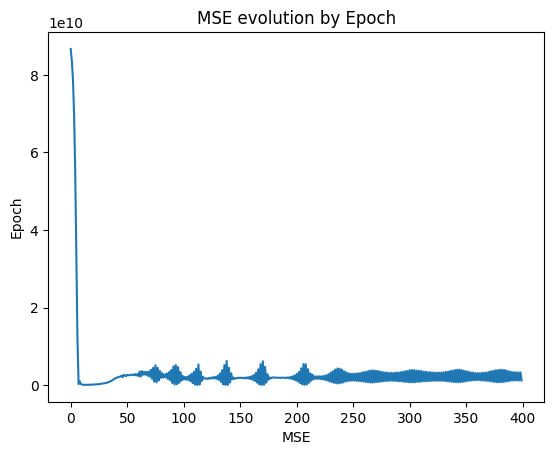

In [621]:
# кривая обучения
plt.plot(history)
plt.title("MSE evolution by Epoch")
plt.xlabel("MSE")
plt.ylabel("Epoch")

In [622]:
# получение предсказаний на тестовой выборке
test_preds = model(X_test).squeeze().tolist()

Text(0, 0.5, 'Баланс')

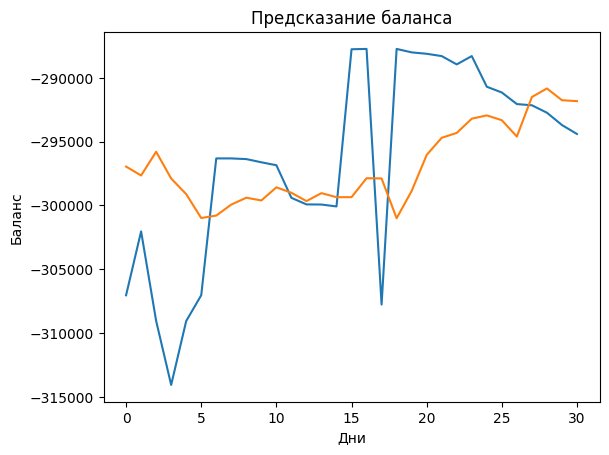

In [623]:
# график предсказаний
plt.plot(y_test)
plt.plot(test_preds)
plt.title('Предсказание баланса')
plt.xlabel('Дни')
plt.ylabel('Баланс')